In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
from dgl.nn import GraphConv
from sklearn.metrics import roc_auc_score

In [86]:
df_2018 = pd.read_csv(r'D:\Final Year Project\Project\Dataset\edge_data_2018_normalized.csv')


In [87]:
unique_countries = pd.concat([df_2018['exporter_id'], df_2018['importer_id']]).unique()
country_to_id = {country: idx for idx, country in enumerate(unique_countries)}

df_2018['exporter_node'] = df_2018['exporter_id'].map(country_to_id)
df_2018['importer_node'] = df_2018['importer_id'].map(country_to_id)

In [88]:
aggregated_df = df_2018.groupby(['exporter_node', 'importer_node'])['value'].sum().reset_index()


In [89]:
df_2018 = aggregated_df

In [90]:
df_2018

,exporter_node,importer_node,value
0,0,5,5.952552e-06
1,0,6,8.678045e-10
2,0,11,3.579498e-08
3,0,14,1.200033e-07
4,0,16,3.166314e-10
...,...,...,...
27423,207,197,3.962606e-06
27424,207,201,2.665336e-06
27425,207,204,1.070839e-07
27426,207,205,3.720004e-03


In [91]:
# Create 2018 graph
g_2018 = dgl.graph((torch.tensor(df_2018['exporter_node'].values, dtype=torch.int64), 
                   torch.tensor(df_2018['importer_node'].values, dtype=torch.int64)))
g_2018.ndata['feat'] = torch.ones((g_2018.num_nodes(), 1), dtype=torch.float32)

In [92]:
# Split 2018 data into train and test
u, v = g_2018.edges()
edge_indices = np.arange(len(u))
train_indices, test_indices = train_test_split(edge_indices, test_size=0.2, random_state=42)


In [93]:
g_train = dgl.edge_subgraph(g_2018, torch.tensor(train_indices, dtype=torch.int64))
g_test = dgl.edge_subgraph(g_2018, torch.tensor(test_indices, dtype=torch.int64))


In [94]:
def generate_negative_edges(g, num_samples):
    num_nodes = g.num_nodes()
    existing_edges = set(zip(g.edges()[0].tolist(), g.edges()[1].tolist()))
    negative_edges = []

    all_possible_edges = set((i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j)
    negative_edges = list(all_possible_edges - existing_edges)
    negative_edges = negative_edges[:num_samples]

    return torch.tensor(negative_edges, dtype=torch.long).t()


In [95]:
neg_train_edges = generate_negative_edges(g_train, len(train_indices))
neg_test_edges = generate_negative_edges(g_test, len(test_indices))

In [96]:
# Load 2019 data
df_2019 = pd.read_csv(r'D:\Final Year Project\Project\Dataset\edge_data_2019_normalized.csv')
df_2019['exporter_node'] = df_2019['exporter_id'].map(country_to_id)
df_2019['importer_node'] = df_2019['importer_id'].map(country_to_id)

aggregated_df = df_2019.groupby(['exporter_node', 'importer_node'])['value'].sum().reset_index()
df_2019 = aggregated_df

# Filter out edges not present in the 2018 graph nodes
df_2019 = df_2019.dropna(subset=['exporter_node', 'importer_node']).astype({'exporter_node': 'int', 'importer_node': 'int'})

#remove self loops
df_2019 = df_2019[df_2019['exporter_node'] != df_2019['importer_node']]


g_2019 = dgl.graph((torch.tensor(df_2019['exporter_node'].values, dtype=torch.int64), 
                   torch.tensor(df_2019['importer_node'].values, dtype=torch.int64)))
g_2019.ndata['feat'] = torch.ones((g_2019.num_nodes(), 1), dtype=torch.float32)


In [97]:
# Define GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)

    def forward(self, g, x):
        x = F.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        return x


In [98]:
# Define link predictor
class LinkPredictor(nn.Module):
    def __init__(self, h_feats):
        super(LinkPredictor, self).__init__()
        self.fc = nn.Linear(2 * h_feats, 1)

    def forward(self, h_src, h_dst):
        h_concat = torch.cat([h_src, h_dst], dim=1)
        return torch.sigmoid(self.fc(h_concat)).squeeze()

In [99]:
# Initialize model, predictor, optimizer, and loss function
in_feats = g_2018.ndata['feat'].shape[1]
h_feats = 128

model = GCN(in_feats, h_feats)
predictor = LinkPredictor(h_feats)

optimizer = torch.optim.Adam(list(model.parameters()) + list(predictor.parameters()), lr=0.01)
loss_fn = nn.BCELoss()

# Train the model on 2018 data
pos_train_u, pos_train_v = g_train.edges()
pos_train_labels = torch.ones(len(pos_train_u))

neg_train_labels = torch.zeros(neg_train_edges.shape[1])

train_u = torch.cat([pos_train_u, neg_train_edges[0]])
train_v = torch.cat([pos_train_v, neg_train_edges[1]])
train_labels = torch.cat([pos_train_labels, neg_train_labels])

In [100]:
for epoch in range(50):
    model.train()

    h = model(g_train, g_train.ndata['feat'])
    h_src = h[train_u]
    h_dst = h[train_v]

    predictions = predictor(h_src, h_dst)
    loss = loss_fn(predictions, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/50, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.6943
Epoch 2/50, Loss: 0.7032
Epoch 3/50, Loss: 0.6872
Epoch 4/50, Loss: 0.6896
Epoch 5/50, Loss: 0.6913
Epoch 6/50, Loss: 0.6881
Epoch 7/50, Loss: 0.6850
Epoch 8/50, Loss: 0.6839
Epoch 9/50, Loss: 0.6842
Epoch 10/50, Loss: 0.6839
Epoch 11/50, Loss: 0.6819
Epoch 12/50, Loss: 0.6794
Epoch 13/50, Loss: 0.6776
Epoch 14/50, Loss: 0.6759
Epoch 15/50, Loss: 0.6734
Epoch 16/50, Loss: 0.6694
Epoch 17/50, Loss: 0.6648
Epoch 18/50, Loss: 0.6605
Epoch 19/50, Loss: 0.6546
Epoch 20/50, Loss: 0.6468
Epoch 21/50, Loss: 0.6401
Epoch 22/50, Loss: 0.6294
Epoch 23/50, Loss: 0.6206
Epoch 24/50, Loss: 0.6078
Epoch 25/50, Loss: 0.5967
Epoch 26/50, Loss: 0.5870
Epoch 27/50, Loss: 0.5764
Epoch 28/50, Loss: 0.5620
Epoch 29/50, Loss: 0.5518
Epoch 30/50, Loss: 0.5494
Epoch 31/50, Loss: 0.5537
Epoch 32/50, Loss: 0.5387
Epoch 33/50, Loss: 0.5277
Epoch 34/50, Loss: 0.5389
Epoch 35/50, Loss: 0.5270
Epoch 36/50, Loss: 0.5230
Epoch 37/50, Loss: 0.5327
Epoch 38/50, Loss: 0.5212
Epoch 39/50, Loss: 0.

In [101]:
# Evaluate the model on 2019 data
pos_test_u, pos_test_v = g_2019.edges()
pos_test_labels = torch.ones(len(pos_test_u))

# Generate negative samples for 2019 evaluation
neg_test_edges = generate_negative_edges(g_2019, len(pos_test_u))
neg_test_labels = torch.zeros(neg_test_edges.shape[1])

test_u = torch.cat([pos_test_u, neg_test_edges[0]])
test_v = torch.cat([pos_test_v, neg_test_edges[1]])
test_labels = torch.cat([pos_test_labels, neg_test_labels])

In [102]:
len(neg_test_labels)

14602

2019 Test AUC: 0.9262
Accuracy: 0.7920
Precision: 0.9407
Predicted Links (Node Indices): [(0, 5), (0, 11), (0, 14), (0, 32), (0, 35), (0, 48), (0, 49), (0, 58), (0, 63), (0, 66), (0, 85), (0, 87), (0, 92), (0, 102), (0, 112), (0, 139), (0, 143), (0, 151), (0, 159), (0, 164), (0, 174), (0, 175), (0, 176), (0, 183), (0, 196), (0, 205), (1, 2), (1, 5), (1, 6), (1, 10), (1, 11), (1, 14), (1, 19), (1, 21), (1, 26), (1, 32), (1, 33), (1, 35), (1, 36), (1, 40), (1, 43), (1, 48), (1, 49), (1, 52), (1, 53), (1, 55), (1, 58), (1, 61), (1, 63), (1, 66), (1, 74), (1, 84), (1, 85), (1, 86), (1, 87), (1, 92), (1, 95), (1, 102), (1, 103), (1, 105), (1, 109), (1, 112), (1, 116), (1, 129), (1, 133), (1, 139), (1, 140), (1, 143), (1, 145), (1, 147), (1, 148), (1, 151), (1, 153), (1, 159), (1, 164), (1, 170), (1, 174), (1, 175), (1, 176), (1, 183), (1, 190), (1, 196), (1, 205), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 10), (2, 11), (2, 12), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 21)

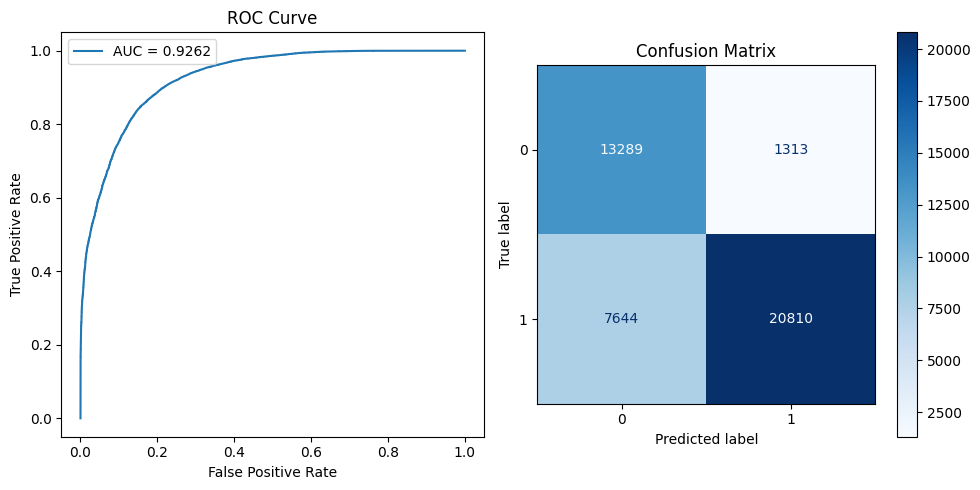

In [103]:
model.eval()
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

model.eval()
with torch.no_grad():
    h = model(g_2019, g_2019.ndata['feat'])
    h_src = h[test_u]
    h_dst = h[test_v]

    predictions = predictor(h_src, h_dst)
    test_labels_np = test_labels.numpy()
    predictions_np = predictions.numpy()

    # Compute AUC
    auc = roc_auc_score(test_labels_np, predictions_np)
    print(f"2019 Test AUC: {auc:.4f}")

    # Binarize predictions with a threshold of 0.5
    predicted_labels = (predictions >= 0.5).int()

    # Compute accuracy
    accuracy = accuracy_score(test_labels_np, predicted_labels.numpy())
    print(f"Accuracy: {accuracy:.4f}")

    # Compute precision
    precision = precision_score(test_labels_np, predicted_labels.numpy())
    print(f"Precision: {precision:.4f}")

    # Identify predicted links
    predicted_positive_indices = (predicted_labels == 1).nonzero(as_tuple=True)[0]
    predicted_links = list(zip(test_u[predicted_positive_indices].numpy(), 
                               test_v[predicted_positive_indices].numpy()))

    # Map node indices back to country IDs
    id_to_country = {idx: country for country, idx in country_to_id.items()}
    predicted_links_countries = [(id_to_country[u], id_to_country[v]) for u, v in predicted_links]

    print("Predicted Links (Node Indices):", predicted_links)
    print("Predicted Links (Country IDs):", predicted_links_countries)
    import matplotlib.pyplot as plt

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(test_labels_np, predictions_np)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plot confusion matrix
    cm = confusion_matrix(test_labels_np, predicted_labels.numpy())
    plt.subplot(1, 2, 2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('Confusion Matrix')
    predicted_links_df = pd.DataFrame(predicted_links_countries, columns=['Exporter', 'Importer'])
    predicted_links_df.to_csv('predicted_links_2019.csv', index=False)
    plt.tight_layout()
    plt.show()
